# First steps

In [1]:
from jax import config
config.update("jax_debug_nans", True)

import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning/")
import json_tricks as json
import copy
from functools import partial

from tqdm import tqdm
import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp
import jax
import pandas as pd
import haiku as hk
from jax.experimental import optimizers

import config

import utils
import metrics
import time
import plot
import stein
import kernels
import svgd
import distributions
import nets
import kernel_learning

from jax.experimental import optimizers

key = random.PRNGKey(0)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
# estimate KSD and Var(\hat KSD) values for base kernels
def estimate_ksd_and_stddev(n: int, m: int, kernels, proposal, target):
    """
    n: number of particles
    m: number of draws for variance estimation
    kernels: list of kernel functions
    
    Returns
    ksds: mean ksd value for each kernel
    stds: standard dev for each kernel
    """
    ksds_list = [[] for kernel in kernels]
    @partial(jit, static_argnums=1)
    def sample_ksd(samples, kernel):
        return stein.ksd_squared_u(samples, target.logpdf, kernel, False)
    for _ in tqdm(range(m)):
        samples = proposal.sample(n)
        for kernel_ksds, kernel in zip(ksds_list, kernels):
            ksd = sample_ksd(samples, kernel)
            kernel_ksds.append(ksd)
    
    ksds = onp.mean(ksds_list, axis=1)
    stds = onp.std(ksds_list, axis=1)
    return ksds, stds

#### Plot everything

In [3]:
def plot_training(training_ksds, ksds, stds, ax=None, lims=None):
    if ax is None:
        ax = plt.gca()
    grid_ksds = np.asarray(training_ksds)
    ax.plot(grid_ksds, "--k", label="Optimized KSD")

    labels = ("k(x, y)=1 constant", "RBF with bandwidth 1", "RBF composed with funnel")
    cycle = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
    for label, ksd, std, errorbar_xpos in zip(labels, ksds, stds, len(grid_ksds)*np.array([1/3, 2/3, 0.9])):
        col = next(cycle)
        ax.axhline(y=ksd, label=label, color=col, linestyle="--")
        ax.errorbar(errorbar_xpos, ksd, yerr=std, color=col, capsize=5, label="Standard deviation")
    ax.set_xlabel("Steps")
    ax.set_ylabel("KSD")

    ax.set_ylim(lims)
    _ = ax.legend()

### Parameters

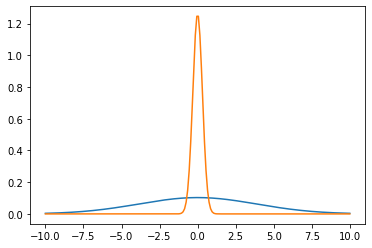

In [4]:
proposal = distributions.Gaussian(0, 0.1)
target = distributions.Gaussian(0, 15)
sizes = [1]

plot.plot_fun(target.pdf, (-10, 10))
plot.plot_fun(proposal.pdf, (-10, 10))

### Train

In [5]:
learner = kernel_learning.KernelLearner(key, target, sizes, kernels.get_rbf_kernel(1), 1, 0)

In [6]:
svgd = kernel_learning.SVGD(key, target, proposal, 400, learner.get_kernel, .1)

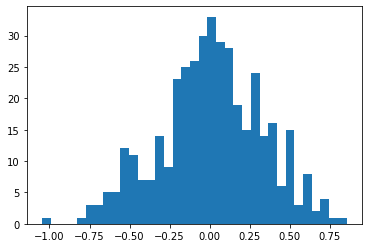

In [7]:
samples = svgd.get_params()
for _ in range(50):
    learner.step(samples)
_ = plt.hist(samples[:, 0], bins=35)

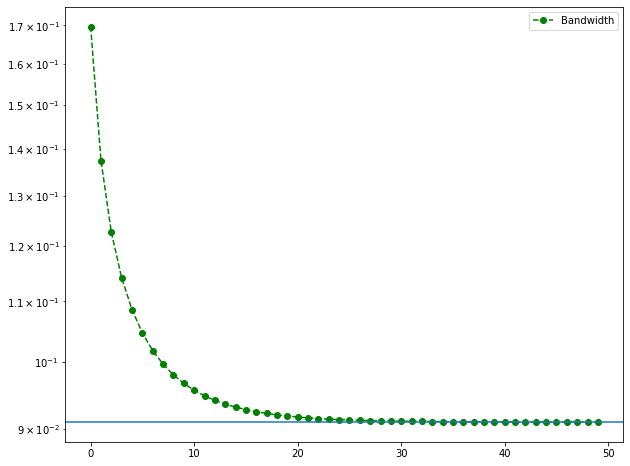

In [8]:
fig, ax = plt.subplots(figsize=[10,8])
bandwidths = np.squeeze(np.array(learner.rundata["bandwidth"]))
plt.plot(bandwidths, "--o", label="Bandwidth", color="green")
plt.axhline(onp.mean(bandwidths[-5:]))
plt.yscale("log")
plt.legend()

In [9]:
svgd.step(learner.get_params())
svgd.rundata["leader_variance"]

[DeviceArray([0.10898993], dtype=float32)]

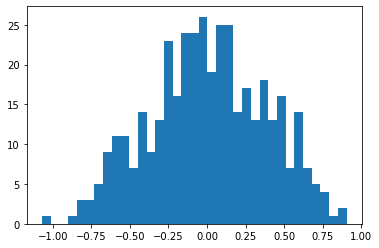

In [10]:
samples = svgd.get_params()
# samples = samples + random.normal(subkey) * 
# samples = distributions.Gaussian(0, 0.362).sample(400)
# print("var =", np.var(samples))
# print("mean =", np.mean(samples))
# print("len =", len(samples))
# for _ in range(50):
#     learner.step(samples)

_ = plt.hist(samples[:, 0], bins=35)

In [11]:
# plot.scatter(samples)

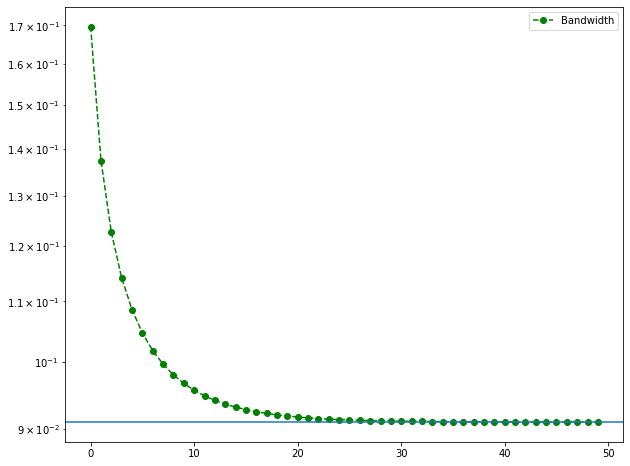

In [12]:
fig, ax = plt.subplots(figsize=[10,8])
bandwidths = np.squeeze(np.array(learner.rundata["bandwidth"]))
plt.plot(bandwidths, "--o", label="Bandwidth", color="green")
plt.axhline(onp.mean(bandwidths[-5:]))
plt.yscale("log")
plt.legend()

## plot learned kernel

In [13]:
params = learner.opt.get_params(learner.optimizer_state)
learned_kernel = learner.get_kernel(params)

In [14]:
s = proposal.sample(100)
learned_kernel(s[4], s[10])

DeviceArray(0.98955667, dtype=float32)

# Plot the kernel

In [15]:
bandwidths[-1]

DeviceArray(0.0909373, dtype=float32)

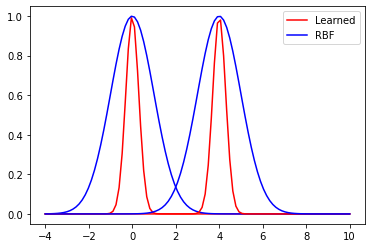

In [16]:
grid = np.linspace(-4, 10, 100).reshape(100,1)
x = np.array([0.])
plt.plot(grid, vmap(learned_kernel, (0, None))(grid, x), label="Learned", color="r")
plt.plot(grid, vmap(kernels.get_rbf_kernel(1),  (0, None))(grid, x), label="RBF", color="b")
x = np.array([4.])
plt.plot(grid, vmap(learned_kernel, (0, None))(grid, x), color="r")
plt.plot(grid, vmap(kernels.get_rbf_kernel(1),  (0, None))(grid, x), color="b")

plt.legend()